In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score, mean_squared_error

In [2]:
df_raw = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0)
df=df_raw.asfreq('H')

In [3]:
week = 24*7
month = week*4
step = 0
errors = {}

In [4]:
while step<=(df.shape[0]//week):
    
    date_from = step*week
    date_to = month + date_from
    
    if (date_to+24) > df.shape[0]:
        print('Complete')
        break
    
    sample = df[date_from : date_to].copy()
    
    target = 'NO2 (ppb)'
    steps = int(sample.shape[0]*0.1)
    
    train = sample[:-steps]
    test = sample[-steps:]
    
    train_y, train_X = train[target], train.drop(columns=[target, 'PM1 (ug/m3)', 'PM2.5 (ug/m3)','PM10 (ug/m3)', 'Temp (C)'])
    test_y, test_X = test[target], test.drop(columns=[target, 'PM1 (ug/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'Temp (C)'])
    
    p,d,q = 1,1,2
    P,D,Q,m = 1,0,1,24
    
    sarimax_model = ARIMA(endog=train_y, exog=train_X, order=(p,d,q), seasonal_order=(P,D,Q, m))
    sarimax_results = sarimax_model.fit(method_kwargs={"warn_convergence": False})
    
    prediction_steps = 24
    predictions = sarimax_results.get_forecast(prediction_steps, exog=test_X[:prediction_steps])
    
    predicted_values_sarimax = predictions.summary_frame()['mean']
    actual = test_y[:prediction_steps]
    
    errors_list = [mean_absolute_error(predicted_values_sarimax, actual),
                   mean_squared_error(predicted_values_sarimax, actual),
                   mean_absolute_percentage_error(predicted_values_sarimax, actual),
                   r2_score(predicted_values_sarimax, actual)]
    
    
    
    errors[str(df.index[date_to+24].date())] = errors_list
    step += 1

IndexError: index 3552 is out of bounds for axis 0 with size 3552

In [9]:
errors_df = pd.DataFrame(errors).T.round(2)
errors_df.columns=['MAE', 'MSE', 'MAPE', 'R2']
errors_df.index = pd.to_datetime(errors_df.index)
errors_df.to_csv(f"Plots/sarimax/{target}rolling_week.csv")
errors_df

,MAE,MSE,MAPE,R2
2022-05-09,9.52,111.26,0.15,0.15
2022-05-16,3.60,18.00,0.08,0.85
2022-05-23,3.69,23.08,0.15,0.88
2022-05-30,7.32,76.27,0.13,0.08
2022-06-06,1.70,5.46,0.04,0.97
2022-06-13,5.94,50.22,0.09,0.55
2022-06-20,3.47,16.82,0.06,0.85
2022-06-27,7.59,90.29,0.16,-0.68
2022-07-04,3.93,19.00,0.09,0.85
2022-07-11,4.23,29.68,0.50,0.87


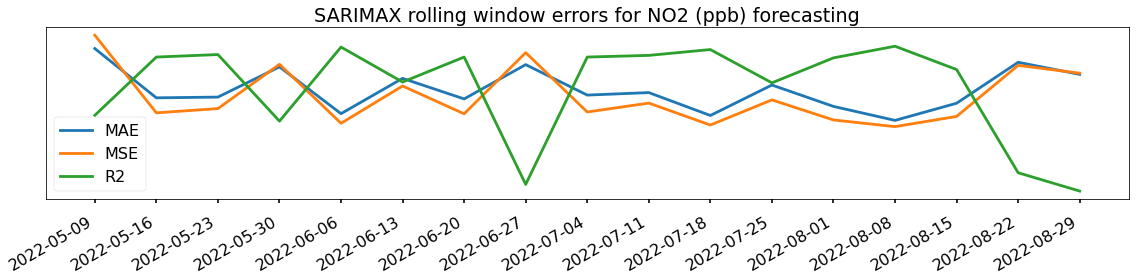

In [10]:
plt.style.use('seaborn-poster')
errors_df_scaled = errors_df.copy()
errors_df_scaled.iloc[:,1] = errors_df_scaled['MSE']/10
errors_df_scaled.iloc[:,2] = errors_df_scaled['MAPE']*10
errors_df_scaled.iloc[:,3] = errors_df_scaled['R2']*10
errors_df_scaled.drop('MAPE', axis=1).plot(figsize=(16,4), x_compat=True)
plt.yticks([])
plt.xticks(errors_df.index)
plt.title(f"SARIMAX rolling window errors for {target} forecasting")
plt.tight_layout()
plt.savefig(f"Plots/sarimax/{target}rolling_week.png")
plt.show()